In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
def compute_correlation(matrix1, matrix2):
    """compute correlation between two sets of variables

    Correlate the rows of matrix1 with the rows of matrix2.
    If matrix1 == matrix2, it is auto-correlation computation
    resulting in a symmetric correlation matrix.
    The number of columns MUST agree between set1 and set2.
    The correlation being computed here is
    the Pearson's correlation coefficient, which can be expressed as

    .. math:: corr(X, Y) = \\frac{cov(X, Y)}{\\sigma_X\\sigma_Y}

    where cov(X, Y) is the covariance of variable X and Y, and

    .. math:: \\sigma_X

    is the standard deviation of variable X

    Reducing the correlation computation to matrix multiplication
    and using BLAS GEMM API wrapped by Scipy can speedup the numpy built-in
    correlation computation (numpy.corrcoef) by one order of magnitude

    .. math::
        corr(X, Y)
        &= \\frac{\\sum\\limits_{i=1}^n (x_i-\\bar{x})(y_i-\\bar{y})}{(n-1)
        \\sqrt{\\frac{\\sum\\limits_{j=1}^n x_j^2-n\\bar{x}}{n-1}}
        \\sqrt{\\frac{\\sum\\limits_{j=1}^{n} y_j^2-n\\bar{y}}{n-1}}}\\\\
        &= \\sum\\limits_{i=1}^n(\\frac{(x_i-\\bar{x})}
        {\\sqrt{\\sum\\limits_{j=1}^n x_j^2-n\\bar{x}}}
        \\frac{(y_i-\\bar{y})}{\\sqrt{\\sum\\limits_{j=1}^n y_j^2-n\\bar{y}}})

    Parameters
    ----------
    matrix1: 2D array in shape [r1, c]
        MUST be continuous and row-major

    matrix2: 2D array in shape [r2, c]
        MUST be continuous and row-major

    Returns
    -------
    corr_data: 2D array in shape [r1, r2]
        continuous and row-major in np.float32
    """
    matrix1 = matrix1.astype(np.float32)
    matrix2 = matrix2.astype(np.float32)
    [r1, d1] = matrix1.shape
    [r2, d2] = matrix2.shape
    if d1 != d2:
        raise ValueError('Dimension discrepancy')
    # preprocess two components
    matrix1 = _normalize_for_correlation(matrix1, 1)
    matrix2 = _normalize_for_correlation(matrix2, 1)
    #print(matrix1.shape)
    #print(matrix2.shape)
    corr_data = np.corrcoef(matrix1, matrix2)
    #print(corr_data.shape)
    #print(d1)
    return corr_data[:r1, r1:]   ###I Believe this is the critical part! we need to fix this and then should be fine
    #According to my understanding, the submatrices AAA[0:90, 0:90]  and AAA[90:,90:] will be the respective "intra-brain" 
    #correlations. What we want is the one that goes across brains, i.e. the lower/upper quadrant. This should be relatively
    #easy to formalize. i.e. corr_data[:r1, r1:]  should be 0:90 rows, but 90:180 columns, which should be the across brain computation.

def _normalize_for_correlation(data, axis):
    """normalize the data before computing correlation
    The data will be z-scored and divided by sqrt(n)
    along the assigned axis
    Parameters
    ----------
    data: 2D array
    axis: int
        specify which dimension of the data should be normalized
    Returns
    -------
    data: 2D array
        the normalized data
    """
    shape = data.shape
    data = zscore(data, axis=axis, ddof=0)
    # if zscore fails (standard deviation is zero),
    # set all values to be zero
    data = np.nan_to_num(data)
    data = data / math.sqrt(shape[axis])
    return data

def isc(D, collapse_subj=True):
    """Intersubject correlation

    For each voxel, computes the correlation of each subject's timecourse with
    the mean of all other subjects' timecourses. By default the result is
    averaged across subjects, unless collapse_subj is set to False.

    Parameters
    ----------
    D : voxel by time by subject ndarray
        fMRI data for which to compute ISC

    collapse_subj : bool, default:True
        Whether to average across subjects before returning result

    Returns
    -------
    ISC : voxel ndarray (or voxel by subject ndarray, if collapse_subj=False)
        pearson correlation for each voxel, across subjects
    """

    n_vox = D.shape[0]
    n_subj = D.shape[2]
    ISC = np.zeros((n_vox, n_subj))

    # Loop across choice of leave-one-out subject
    for loo_subj in range(n_subj):
        group = np.mean(D[:, :, np.arange(n_subj) != loo_subj], axis=2)
        subj = D[:, :, loo_subj]
        for v in range(n_vox):
            ISC[v, loo_subj] = stats.pearsonr(group[v, :], subj[v, :])[0]

    if collapse_subj:
        ISC = np.mean(ISC, axis=1)
    return ISC


def isfc(D, collapse_subj=True):
    """Intersubject functional correlation
    Computes the correlation between the timecoure of each voxel in each
    subject with the average of all other subjects' timecourses in *all*
    voxels. By default the result is averaged across subjects, unless
    collapse_subj is set to False.
    Uses the high performance compute_correlation routine from fcma.util
    Parameters
    ----------
    D : voxel by time by subject ndarray
        fMRI data for which to compute ISFC
    collapse_subj : bool, default:True
        Whether to average across subjects before returning result
    Returns
    -------
    ISFC : voxel by voxel ndarray
        (or voxel by voxel by subject ndarray, if collapse_subj=False)
        pearson correlation between all pairs of voxels, across subjects
    """

    n_vox = D.shape[0]
    n_subj = D.shape[2]
    ISFC = np.zeros((n_vox, n_vox, n_subj))

    # Loop across choice of leave-one-out subject
    for loo_subj in range(D.shape[2]):
        group = np.mean(D[:, :, np.arange(n_subj) != loo_subj], axis=2)
        subj = D[:, :, loo_subj]
        ISFC[:, :, loo_subj] = compute_correlation(group, subj)

        # Symmetrize matrix
        ISFC[:, :, loo_subj] = (ISFC[:, :, loo_subj] +
                                ISFC[:, :, loo_subj].T) / 2

    if collapse_subj:
        ISFC = np.mean(ISFC, axis=2)
    return ISFC


In [3]:
import os, re
import numpy as np
import pandas as pd
import sys
import scipy
import itertools
from collections import defaultdict
from random import sample
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import hypertools as hyp
from scipy import stats

%matplotlib notebook

## 1 Import time series data

In [4]:
# We have 40 subjects
data_dir = '/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/shirer90spheres8mm/'
subjs = ['PSA156', 'PSA019', 'PSA144', 'PSA061', 'PSA120', 'PSA032', 'PSA041', 'PSA079', 'PSA029', 'PSA036', 'PSA078', 'PSA086', 'PSA131', 'PSA132', 'PSA153', 'PSA112', 'PSA056', 'PSA068', 'PSA075', 'PSA108', 'PSA003', 'PSA005', 'PSA007', 'PSA008', 'PSA009', 'PSA010', 'PSA016', 'PSA017', 'PSA026', 'PSA027', 'PSA028', 'PSA030', 'PSA109', 'PSA069', 'PSA119', 'PSA128', 'PSA142', 'PSA094', 'PSA151', 'PSA127']

# 2 Check out the data. For each subject, we have 12 ads, each ad has 32 TRs, and in total we have 90 ROIS.

_we can check out all participants' time series during each ad in Auditory ROI ('V1')_

Question: how do the figures look? Are they too spiky?


<IPython.core.display.Javascript object>


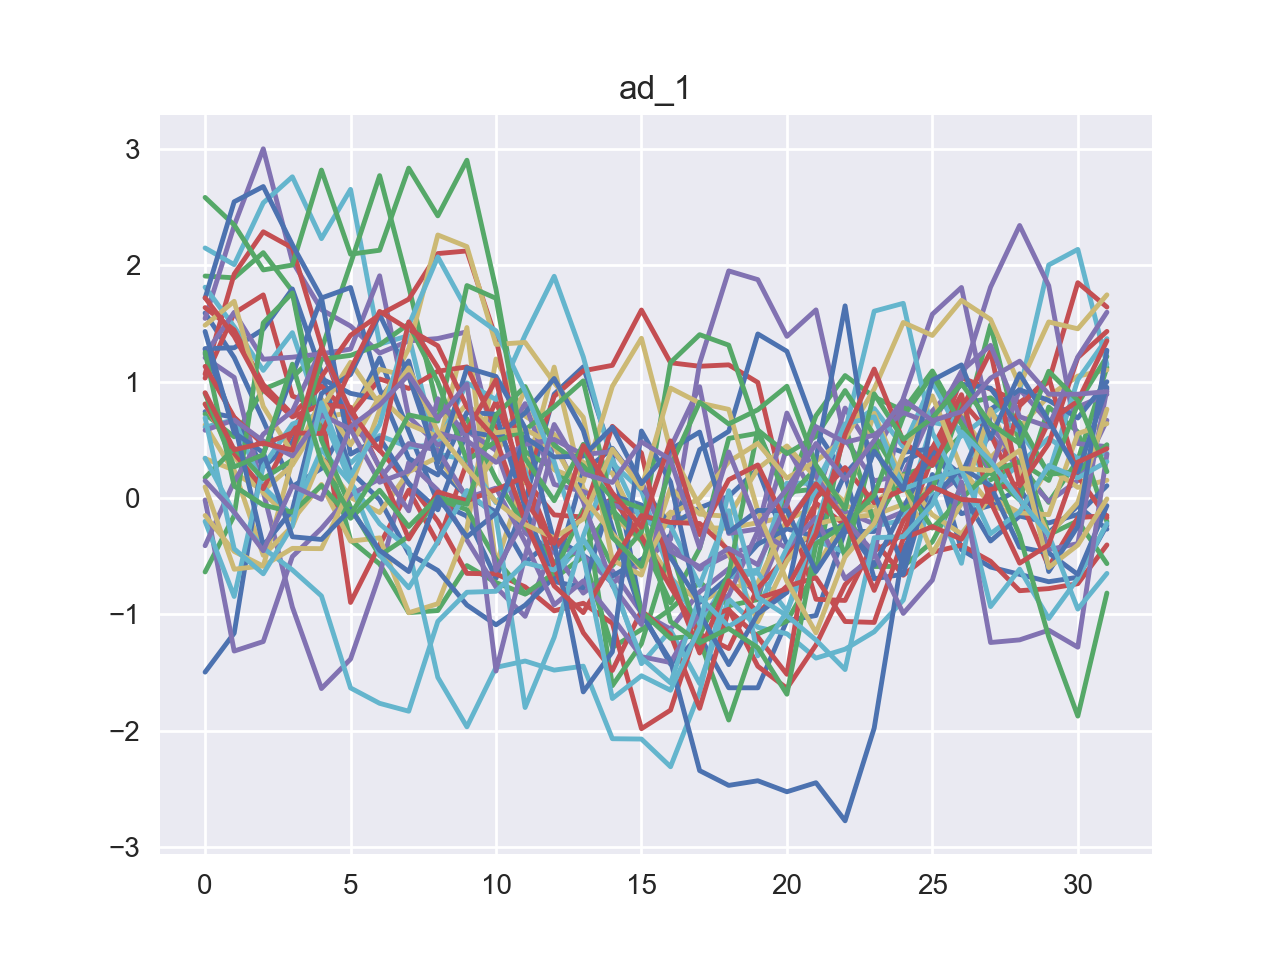

<IPython.core.display.Javascript object>


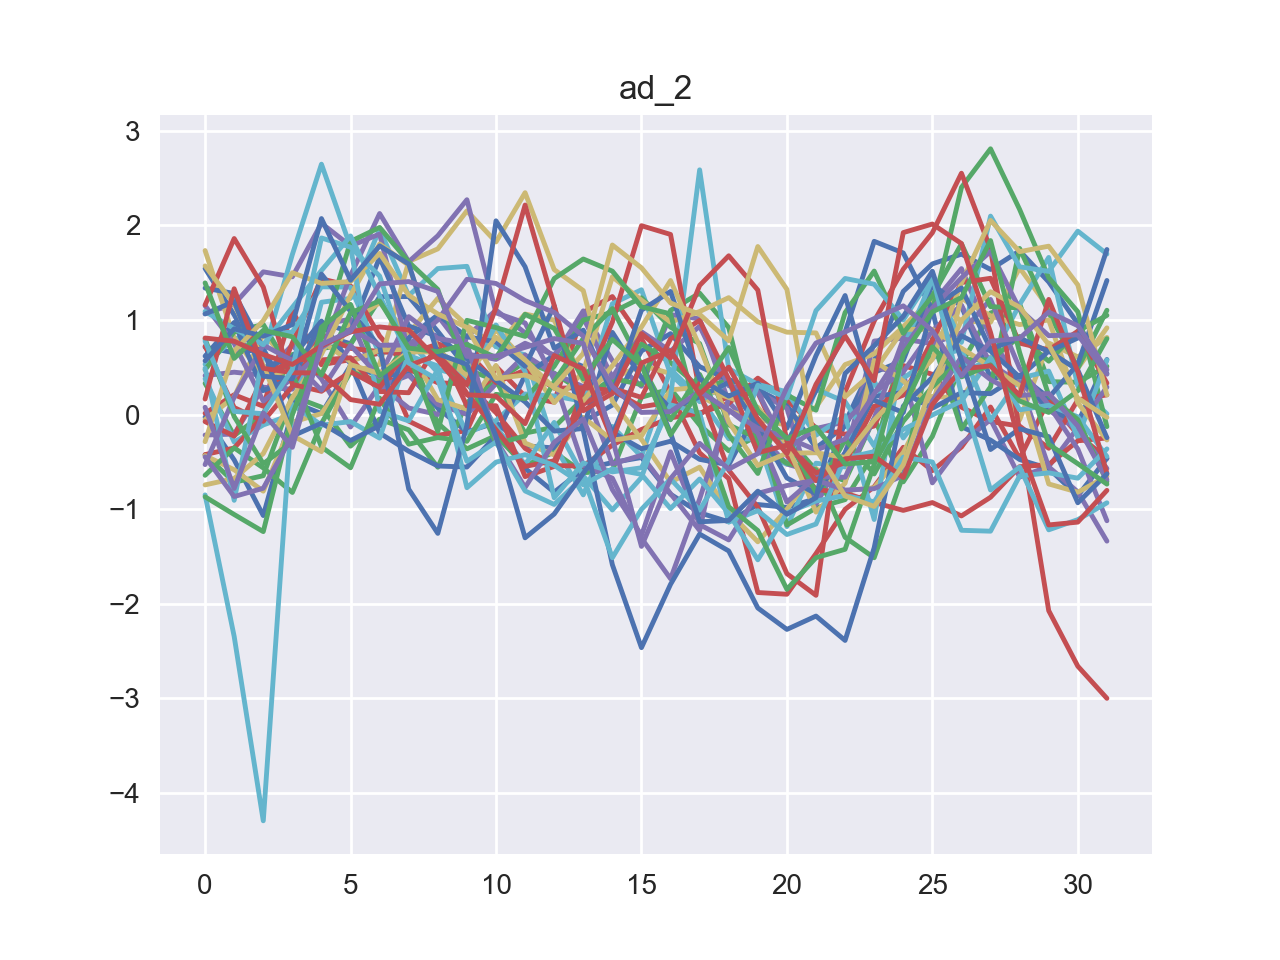

<IPython.core.display.Javascript object>


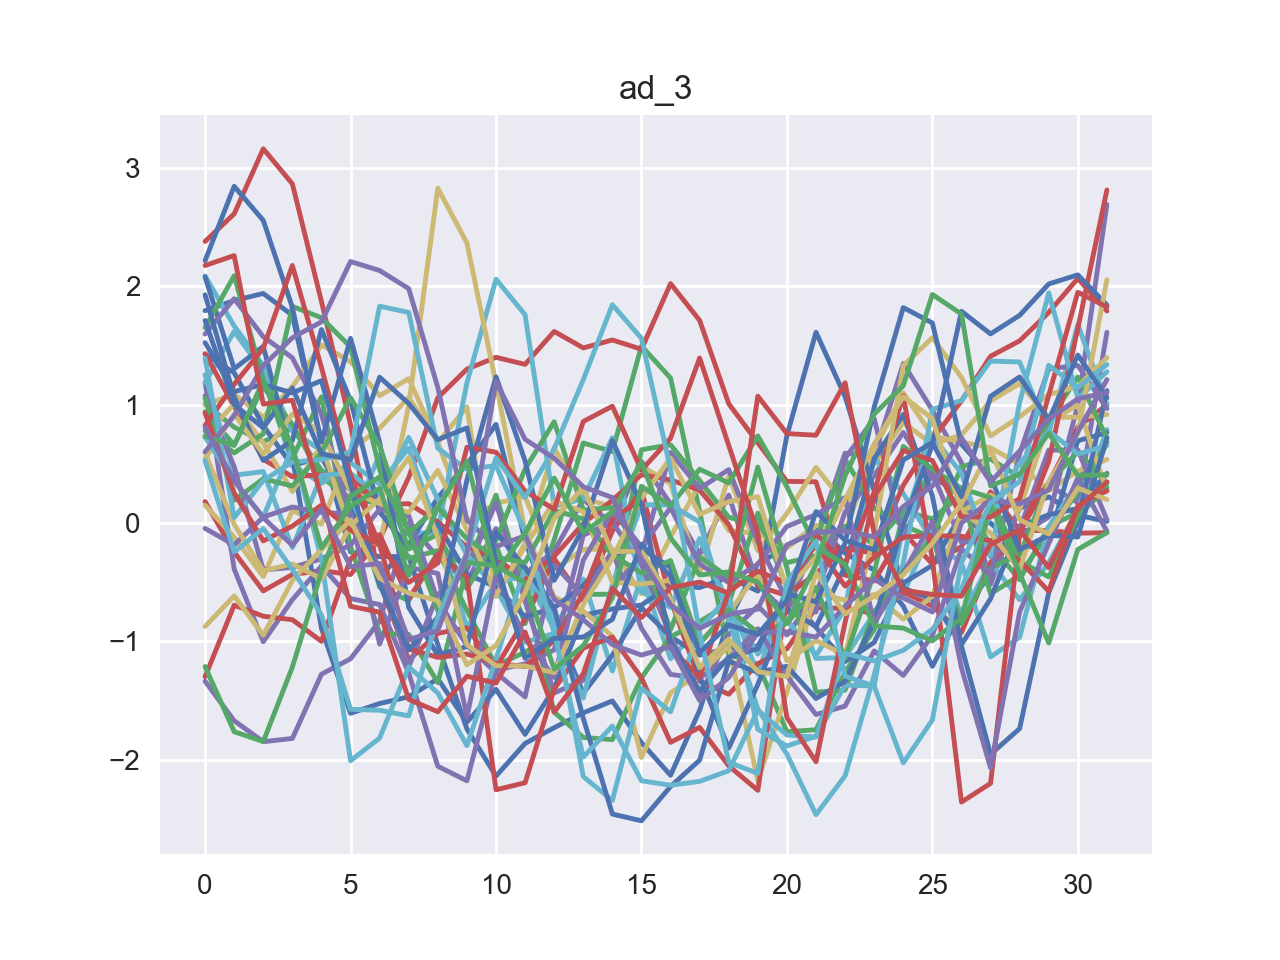

<IPython.core.display.Javascript object>


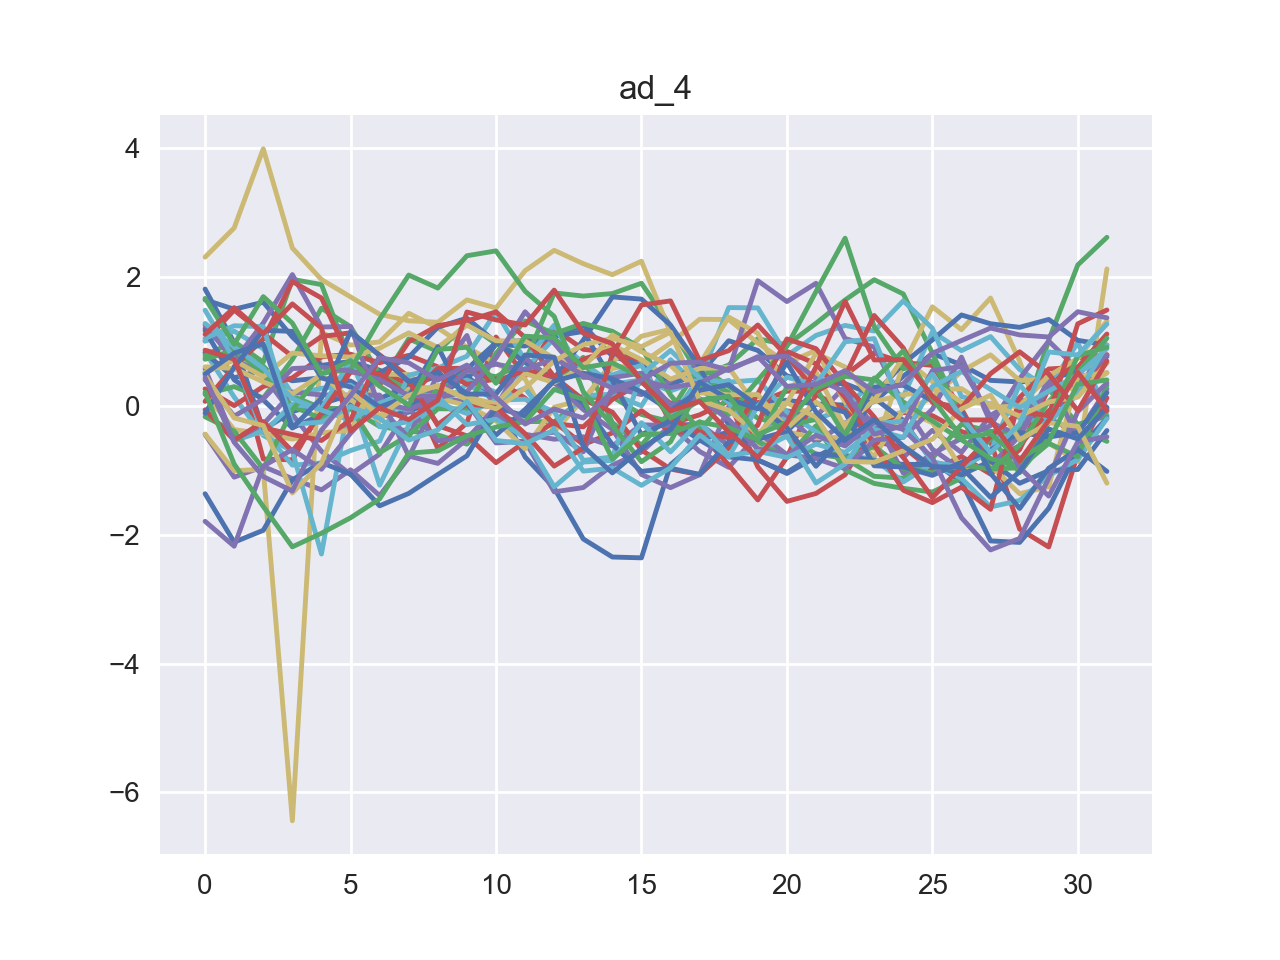

<IPython.core.display.Javascript object>


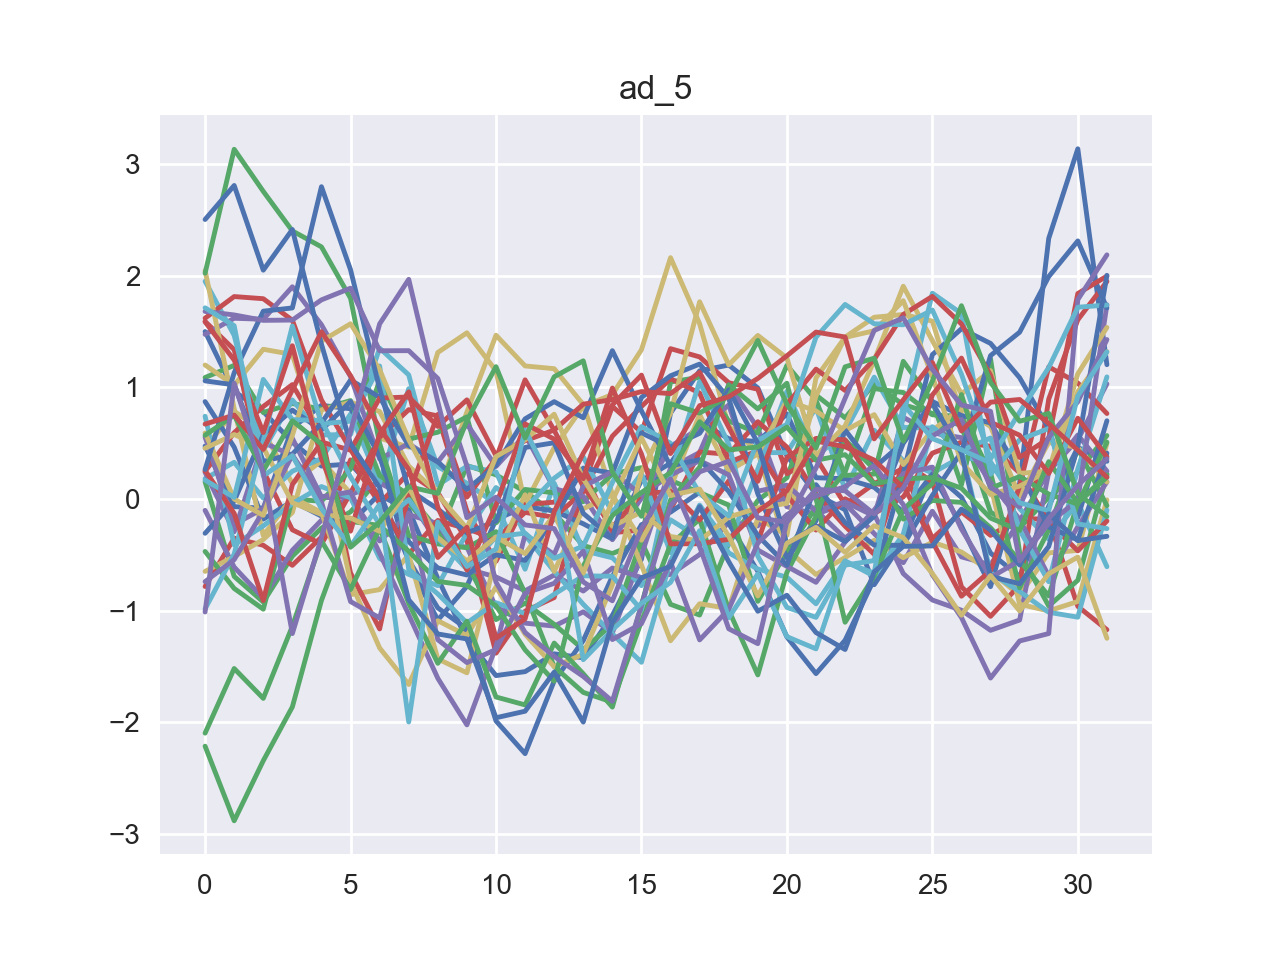

<IPython.core.display.Javascript object>


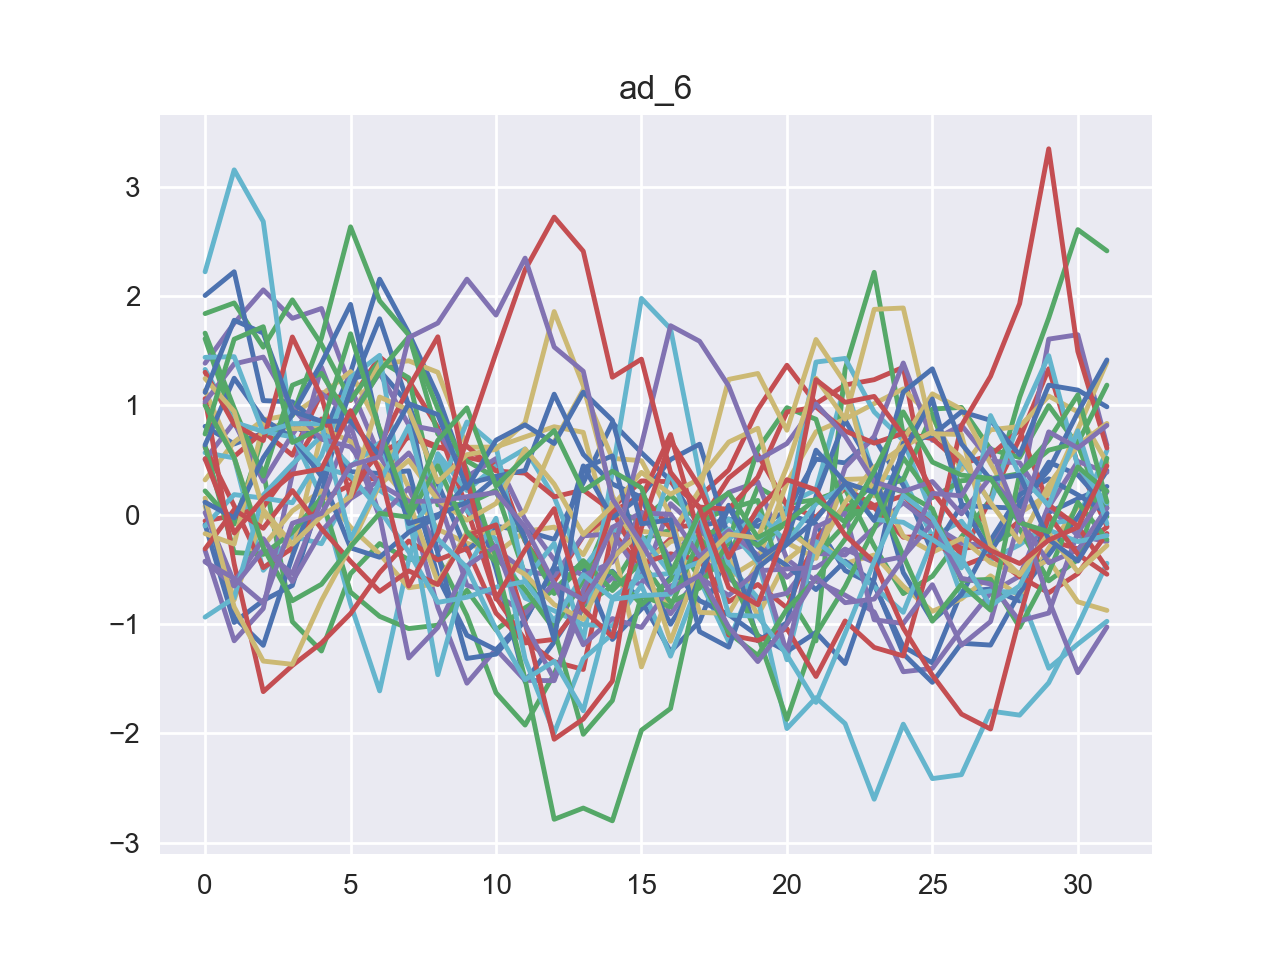

<IPython.core.display.Javascript object>


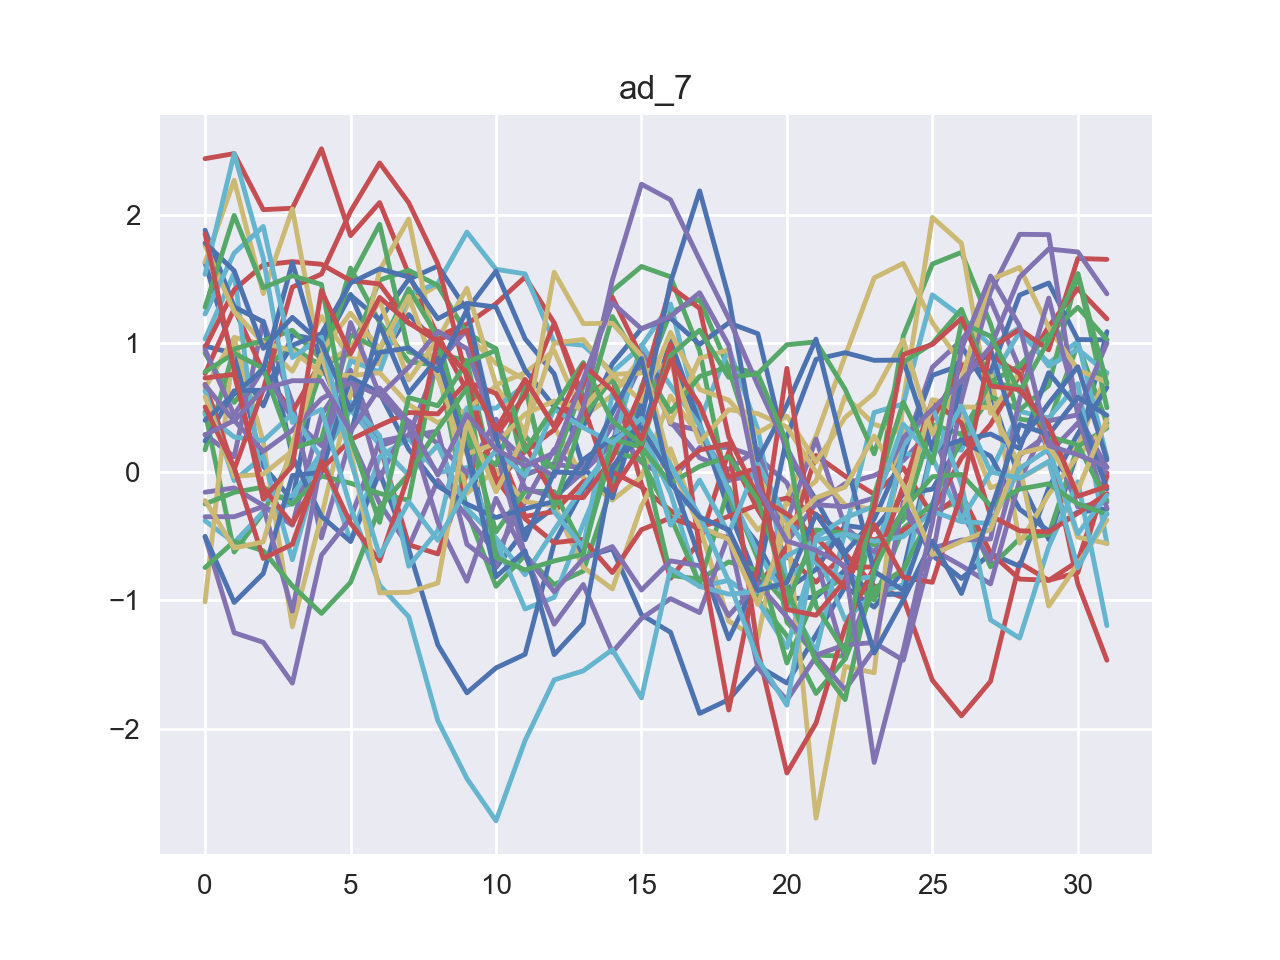

<IPython.core.display.Javascript object>


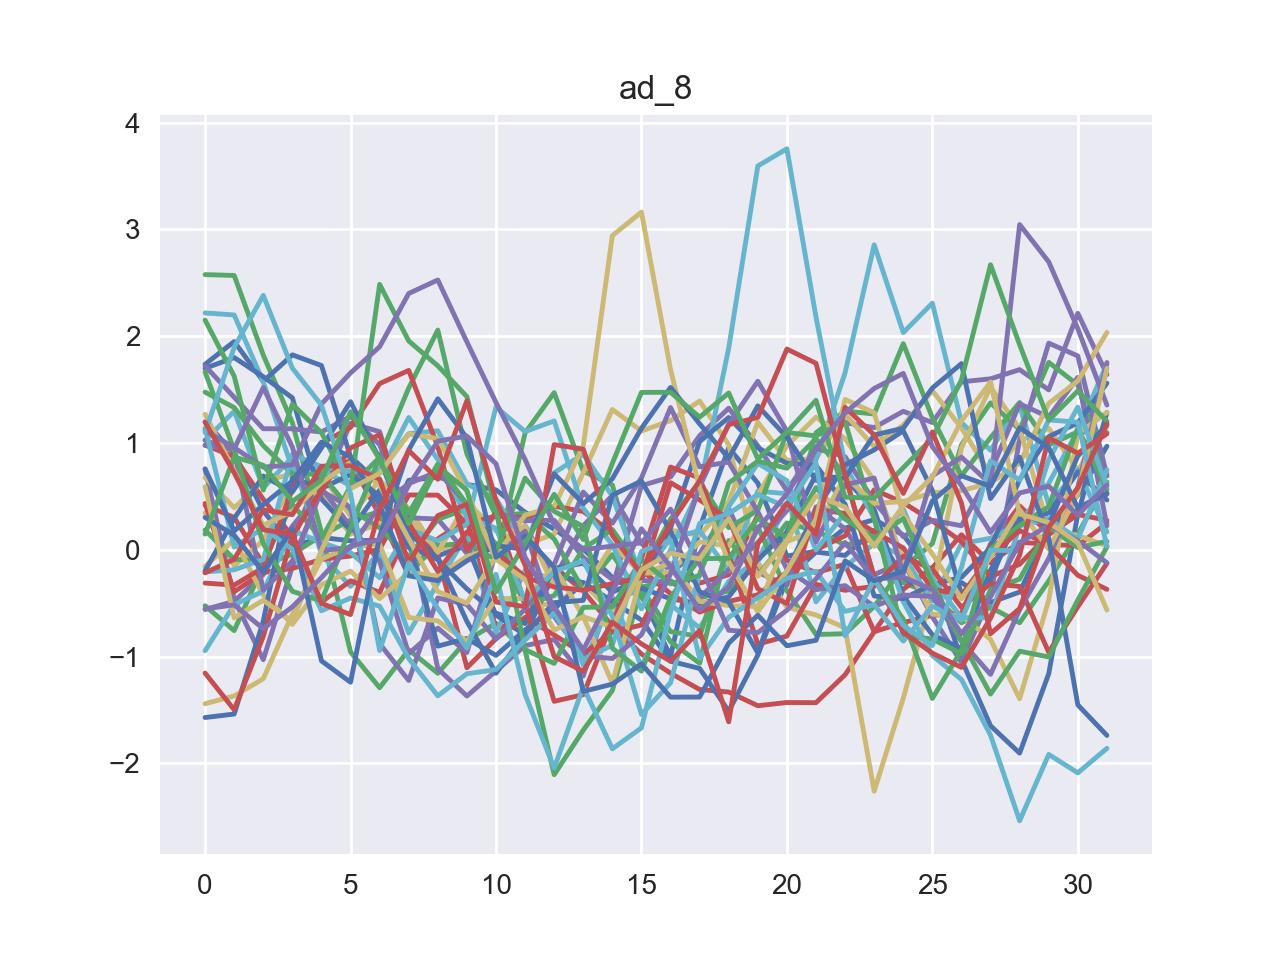

<IPython.core.display.Javascript object>


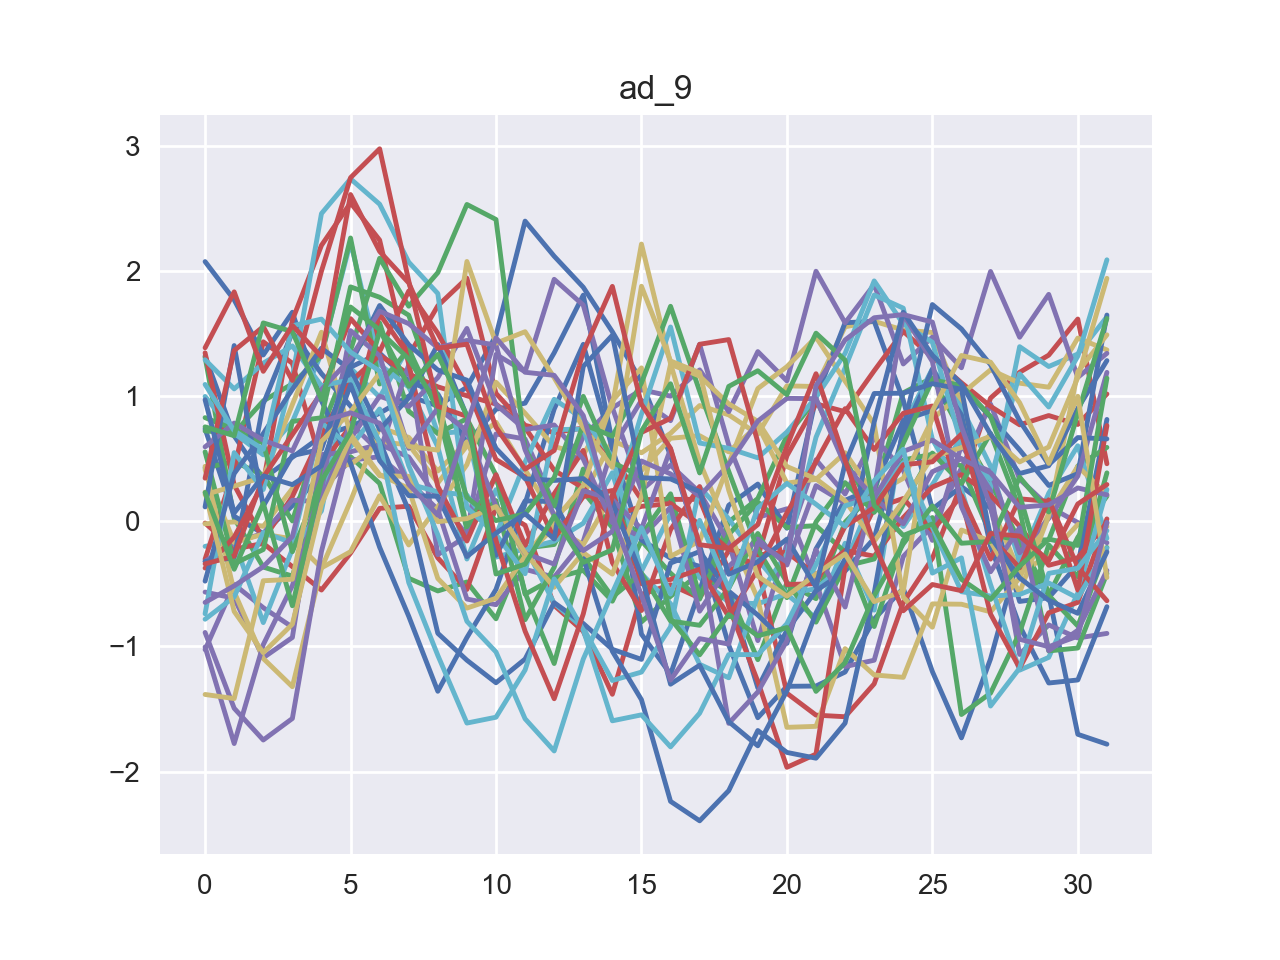

<IPython.core.display.Javascript object>


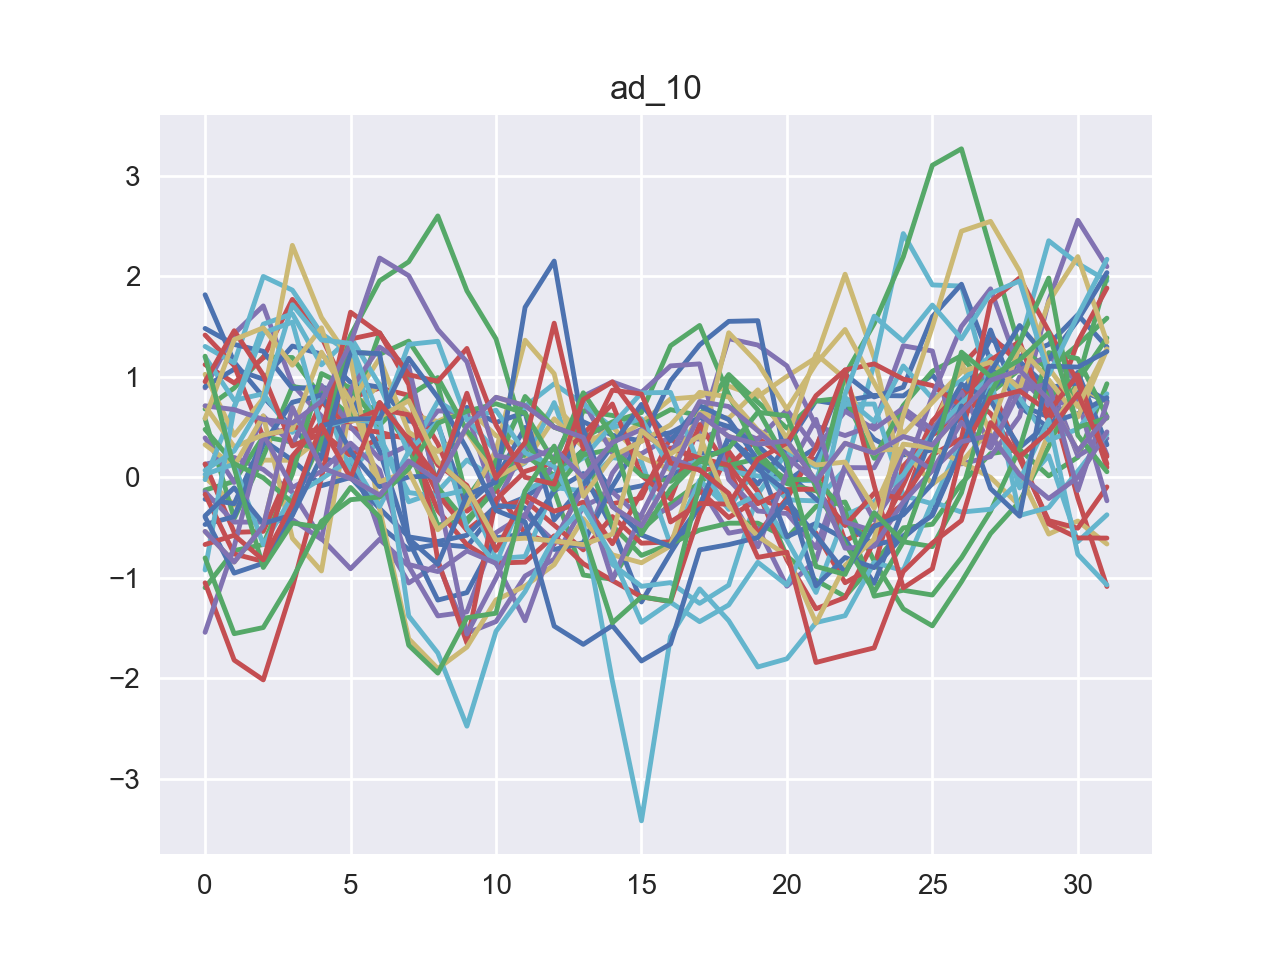

<IPython.core.display.Javascript object>


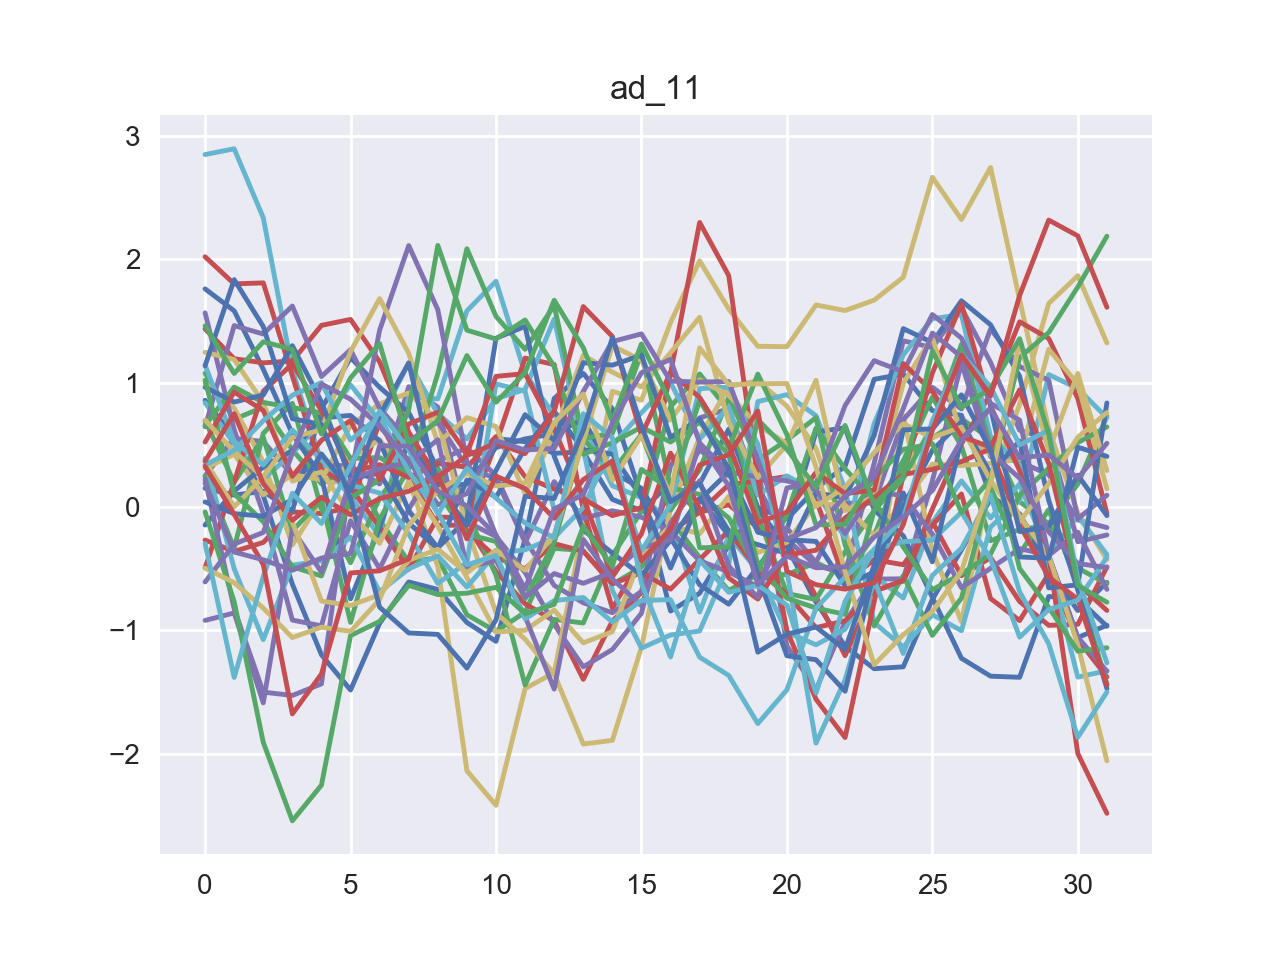

<IPython.core.display.Javascript object>


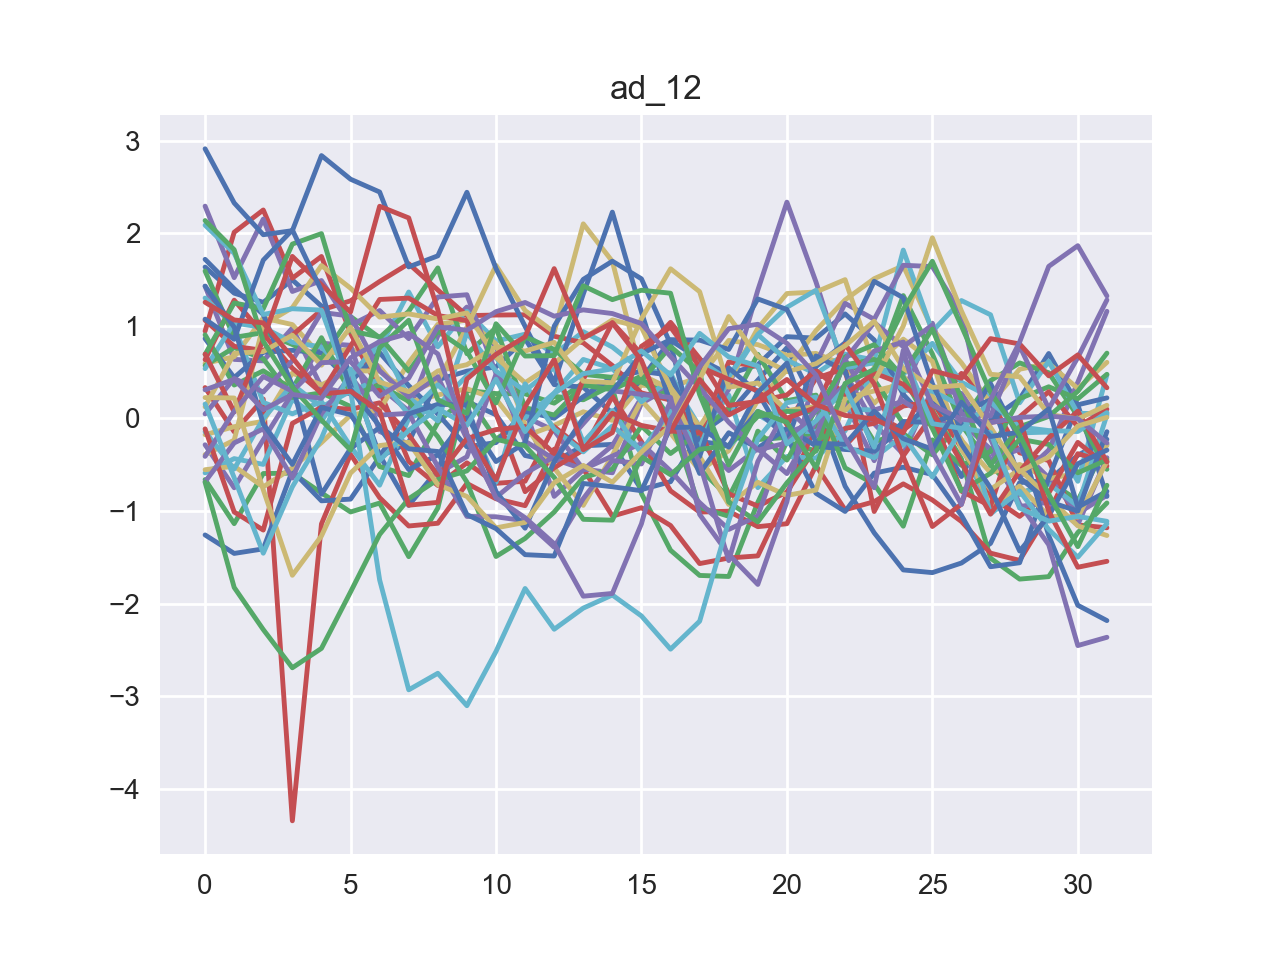

In [5]:
corr = {}
#curr_subj = subjs[0]
for i in range(12):
    plt.figure(i+1)
    for curr_subj in subjs:
        file_name =  curr_subj + '_' + str(i + 1) + '_realcost01.npz'
        if os.path.isfile(os.path.join(data_dir, file_name)):
            time_series = np.load(os.path.join(data_dir, file_name))
            plt.plot(time_series['arr_0'][:,55])
    plt.title('ad_' + str(i+1))
    plt.show()

# 3 Check ISA in each subject for each ad

In [6]:
data_dir = '/Users/Rui/Dropbox/CNLab/peirui.github.io/brain_language/shirer90spheres8mm/'
os.chdir(data_dir)
tr = 31


subj_isc = []

for vID in range(12):
    same_spots = [s for s in os.listdir(data_dir) if s.endswith('_' + str(vID+1) + '_realcost01.npz')]
    same_spotsdata_list = []

    data_list = []
    for i in same_spots:
        d = np.load(i)
        data_list.append(d['arr_0'][:tr,:])

    #stack them into a 3d array and set up array to have the dimenion order that ISFC wants
    spot_data  = np.asarray(data_list)  
    spot_data_v_t_s = spot_data.swapaxes(0,2)

    isc_result = isc(spot_data_v_t_s, collapse_subj=False)
    #print(isc_result.shape)
    subj_isc.append(isc_result[7,:])
    
    
    

    
subj_isc = np.asarray(subj_isc)

In [7]:
subj_isc.shape
subj_isc2 = np.mean(subj_isc, axis=0)

<IPython.core.display.Javascript object>


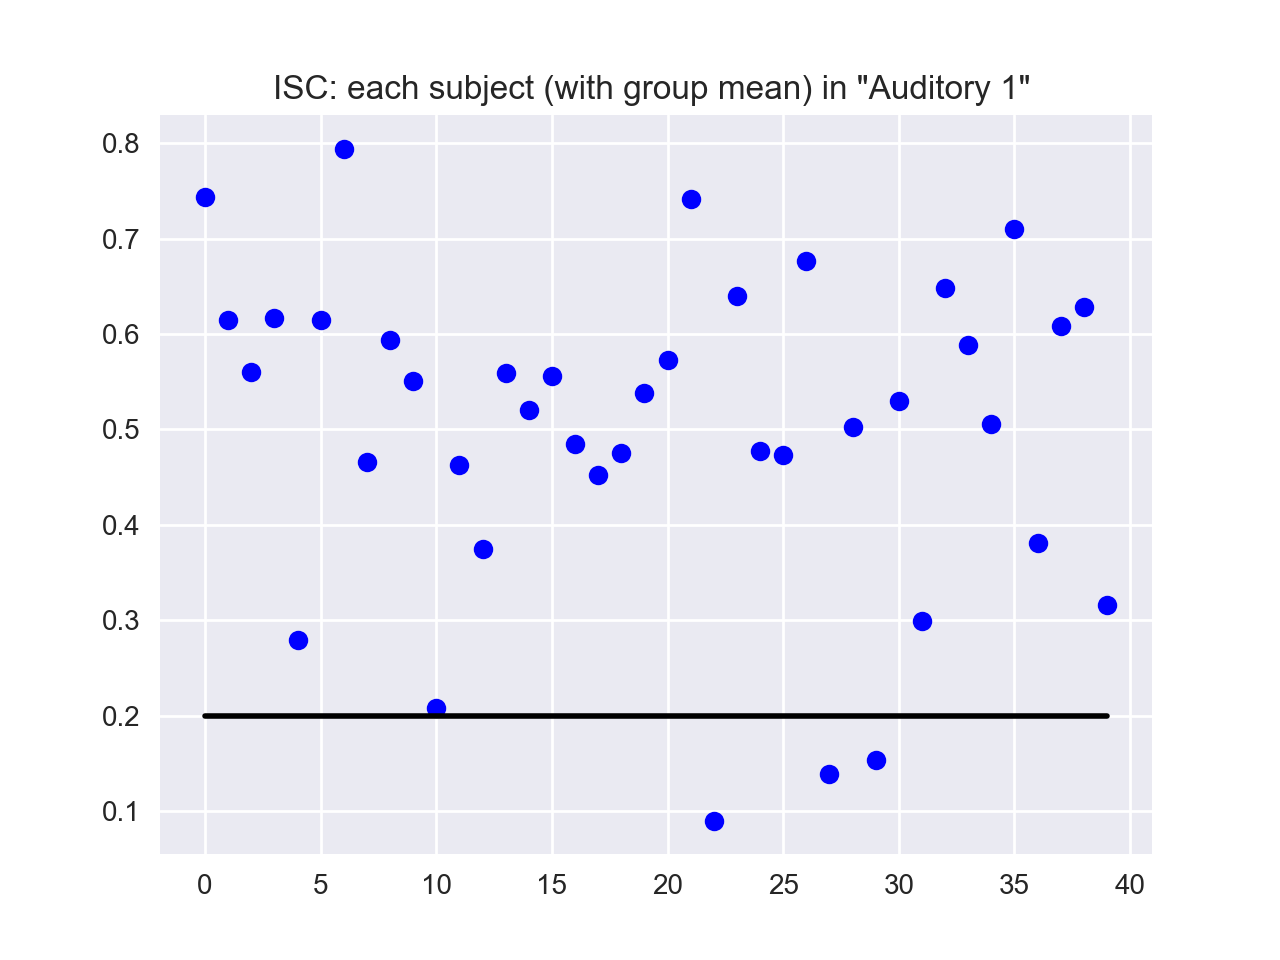

In [8]:
plt.figure(13)
plt.plot(range(40), subj_isc2, 'bo')
plt.plot([0, 39], [0.2, 0.2], 'k-', lw=2)
plt.title('ISC: each subject (with group mean) in "Auditory 1" ')



In [9]:
bad_subjs = [i for i, j in enumerate(subj_isc2) if j <0.2]

In [10]:
for subj in bad_subjs:
    print(subjs[subj])

PSA007
PSA017
PSA027


# 4 visualization using hypertools

In [11]:
#for i in list(itertools.combinations(range(4),2)):
#    subj1 = subjs[i[0]]
#    subj2 = subjs[i[1]]

#    time_series1 = np.load(os.path.join(data_dir, subj1 + '_' + str(1) + '_realcost01.npz'))
#    time_series2 = np.load(os.path.join(data_dir, subj2 + '_' + str(1) + '_realcost01.npz'))


#a = hyp.tools.align([time_series1['arr_0'][:,], time_series2['arr_0'][:,], time_series3['arr_0'][:,33:44]])
#data = hpt.tools.load('weights', align=True)

#    hyp.plot([time_series1['arr_0'], time_series2['arr_0']], align = True, animate= False, ndims=2)
